In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

## Create the dataset

In [22]:
EPS_SIGMA = 0.08

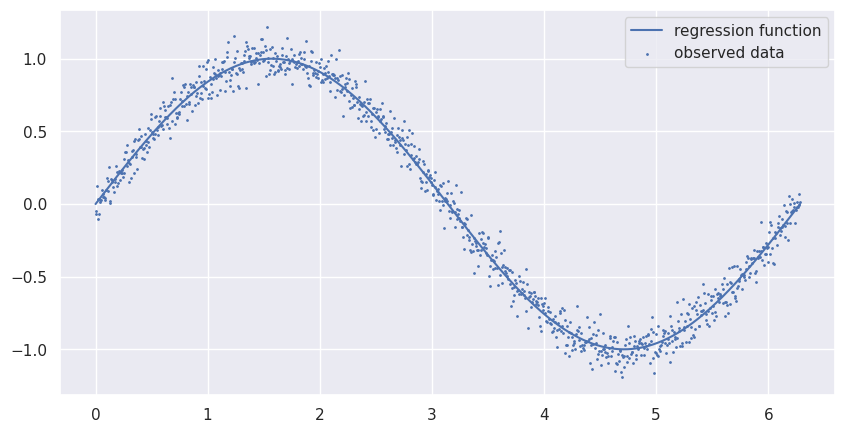

In [73]:
X = np.linspace(0, 2 * np.pi, 1000)
Y = np.sin(X)

eps = np.random.normal(0, EPS_SIGMA, X.shape)
X_train, y_train = X, Y + eps

fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(X,Y, label='regression function')
ax.scatter(X_train, y_train, s=1, label='observed data')
plt.legend()
plt.show()

## Polynomial Linear Basis Function

In [118]:
class PLBF:
    
    def __init__(self, degree):
        self.degree = degree
        self.exponents = np.arange(degree + 1)
        self.output_dim = degree + 1
    
    def __call__(self, x):
        return np.repeat(x, self.degree + 1) ** self.exponents

In [119]:
phi = PLBF(degree=3)
phi(3)

array([ 1,  3,  9, 27])

## Solver

In [77]:
def solve(X_train, y_train, lbf):
    # Compute the design matrix
    design_m = np.stack([ lbf(x) for x in X_train ])

    # Compute the Moore-Penrose pseudo-inverse
    moore_penrose = np.linalg.inv((design_m.T @ design_m)) @ design_m.T

    # Compute the weights
    return moore_penrose @ y_train
    
        
solve(X_train, y_train, phi)

array([-0.2054774 ,  1.9193638 , -0.88466043,  0.09386804])

## Inference

In [81]:
class PolynomialRegression:
    
    def __init__(self, deg):
        self.phi = PLBF(degree=deg)
        self.w = None
        
    def fit(self, X_train, y_train):
        self.w = solve(X_train, y_train, self.phi)
        
    def predict(self, X):
        return np.array([ self.w @ self.phi(x) for x in X ])
        

degree 0 MAE 0.638
degree 1 MAE 0.396
degree 2 MAE 0.396
degree 3 MAE 0.081
degree 4 MAE 0.081
degree 5 MAE 0.062


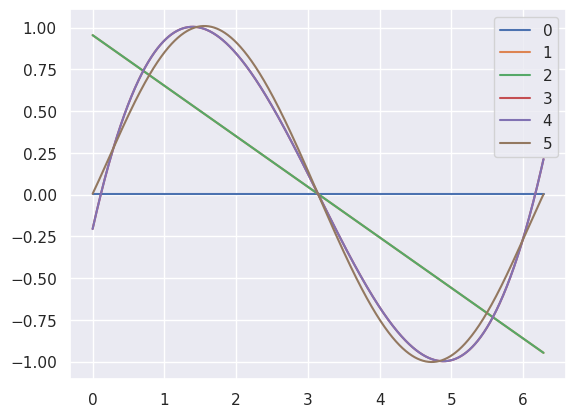

In [90]:
for d in range(6):
    m = PolynomialRegression(deg=d)
    m.fit(X_train, y_train)
    pred_y = m.predict(data_X)
    plt.plot(data_X, pred_y, label=str(d))
    print('degree', d, 'MAE', np.abs(y_train - pred_y).mean().round(3))
    
    
plt.legend()
plt.show()

## Bayesian treatment

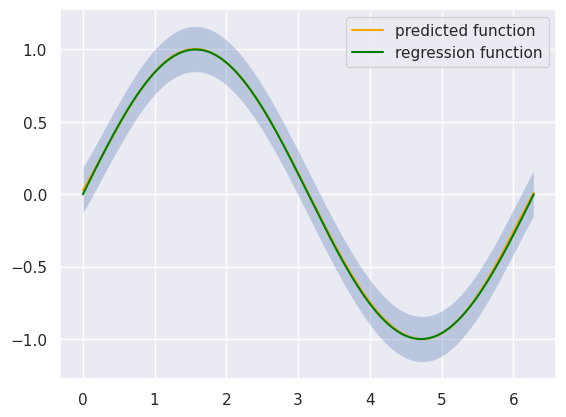

In [176]:
from sklearn.model_selection import train_test_split

class BayesianRegression:
    '''
    weights prior: zero-mean isotropic gaussian
    '''
    
    
    def __init__(self, lbf, noise_precision=20, prior_variance=0.05):
        '''
        '''
        self.lbf = lbf
        self.noise_precision = noise_precision
        self.prior_variance = prior_variance
        self.n_weights = self.lbf.output_dim
        
        # params
        self.m_0 = self.S_0 = None
        self.m_N = self.S_N = None
        self.noise_variance = 1 / self.noise_precision
        
        
    def fit(self, X_train, y_train):
        
        # Compute the mean and cov matrix of prior
        self.m_0 = np.zeros(self.n_weights)
        self.S_0 = self.prior_variance * np.identity(self.n_weights)
        
        # Compute intermediate calculations 
        design_m = np.stack([ self.lbf(x) for x in X_train ])
        S_0_inv = np.linalg.inv(self.S_0)
        
        # Compute the mean and cov matrix of posterior
        self.S_N = np.linalg.inv( S_0_inv + self.noise_precision * (design_m.T @ design_m) )
        self.m_N = self.S_N @ ( S_0_inv @ self.m_0 + self.noise_precision * (design_m.T @ y_train) )
        
    
    def predict(self, X, returns_std=False):
        assert type(X) is np.ndarray, 'use numpy arrays'
        res = np.array([ self.predict_datapoint(x) for x in X ])
        loc = res[:, 0]
        std = np.sqrt(res[:, 1]) if returns_std else res[:, 1]
        return loc, std
        
    def predict_datapoint(self, x):
        '''
        Calculate the predictive distribution parameters
        (mean, variance) at the data point x.
        '''
        phi = self.lbf(x)
        loc_p = self.m_N.T @ phi
        std_p = self.noise_variance + phi.T @ self.S_N @ phi  
        return loc_p, std_p
        
# to check how the result change with dataset size
X_train_subset, _, y_train_subset, _ = train_test_split(X_train, y_train, test_size=0.20)
        
lbf = PLBF(degree=5)
m = BayesianRegression(lbf, noise_precision=40)
m.fit(X_train_subset, y_train_subset)
Y_pred, Y_sigma = m.predict(X_train, returns_std=True)

lower_bound = Y_pred - Y_sigma
upper_bound = Y_pred + Y_sigma
plt.fill_between(X_train, lower_bound, upper_bound, alpha=0.3)
plt.plot(X_train, Y_pred, color='orange', label='predicted function')
plt.plot(X, Y, color='green', label='regression function')

plt.legend()
plt.show()